<a href="https://colab.research.google.com/github/llai7/MATH227C/blob/main/Math227C20Sp_P09_LuluLai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 9

## Example: predicting colon cancer from stool microbiome composition

In [ ]:
# plot settings
options(repr.plot.width=15, repr.plot.height=10)

In [1]:
# Install a package BioConductor ExperimentHub to access the example data
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install()
BiocManager::install("ExperimentHub")

# Install glmnet for LASSO and Elastic Net regression
install.packages("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.18), R 4.2.0 (2022-04-22)

Installing package(s) 'BiocVersion'

Old packages: 'openssl', 'roxygen2', 'tinytex', 'usethis', 'xfun'

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.18), R 4.2.0 (2022-04-22)

Installing package(s) 'ExperimentHub'

also installing the dependencies ‘bitops’, ‘zlibbioc’, ‘RCurl’, ‘GenomeInfoDbData’, ‘XVector’, ‘GenomeInfoDb’, ‘lazyeval’, ‘png’, ‘Biostrings’, ‘httpuv’, ‘xtable’, ‘fontawesome’, ‘sourcetools’, ‘later’, ‘promises’, ‘htmlwidgets’, ‘crosstalk’, ‘Rcpp’, ‘plogr’, ‘Biobase’, ‘IRanges’, ‘KEGGREST’, ‘shiny’, ‘DT’,

In [2]:

library("BiocManager")
library("glmnet")


Loading required package: Matrix

Loaded glmnet 4.1-4



In [3]:
library("ExperimentHub")

eh = ExperimentHub()
data = eh[["EH361"]]


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: AnnotationHub

Loading required package: BiocFileCache

Loading required package: dbplyr

snapshotDate(): 2022-04-26

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.15 (BiocManager 1.30.18), R 4.2.0 (2022-04-22)

Installing

## 1. Explore the data set

Explore our data set. The rows are the presence of microbes in the gut. They also contain the presence of cancer. The columns represent different patients. 

__i) How many patients are in the data set?__

__ii) How many species of microbe are in the data set?__

There are possible 3 disease states. Create a data set with only patients who are either "N" (No cancer) or "cancer" (cancer). In other words, remove the patiends with adenomas.

__iii) After removing the patients with adenomas, how many patients are in the data set?__

In [ ]:
print(paste('There are',ncol(data),'patients.' ,sep=' '))

[1] "There are 156 patients."


In [ ]:
print(paste('There are',nrow(data),'species of microbe in the data set.' ,sep=' '))

[1] "There are 1505 species of microbe in the data set."


For simplicity, let's only use the "n" and "cancer" states (and remove the adenomas).


In [5]:
dataCancerNoCancer = data[, data$disease %in% c("n", "cancer")]

#print(paste('There are',ncol(dataCancerNoCancer),'patients in the data set now.' ,sep=' '))

[1] "There are 114 patients in the data set now."


## 2. Lasso regression
Let's perform lasso regression. In this case, the response variable is categorical (cancer or no cancer) so we can use a binomial model, which is a subset of logistic models. 

__i) According to the crossvalidation analysis, how many species of microbe should we include in a predictive model of colon cancer?__

In [62]:
y = factor(dataCancerNoCancer$disease)
x = t(exprs(dataCancerNoCancer))

lassoFit = glmnet(y=y, x=x, family="binomial")

#plot(lassoFit, xvar = "lambda", label = TRUE)


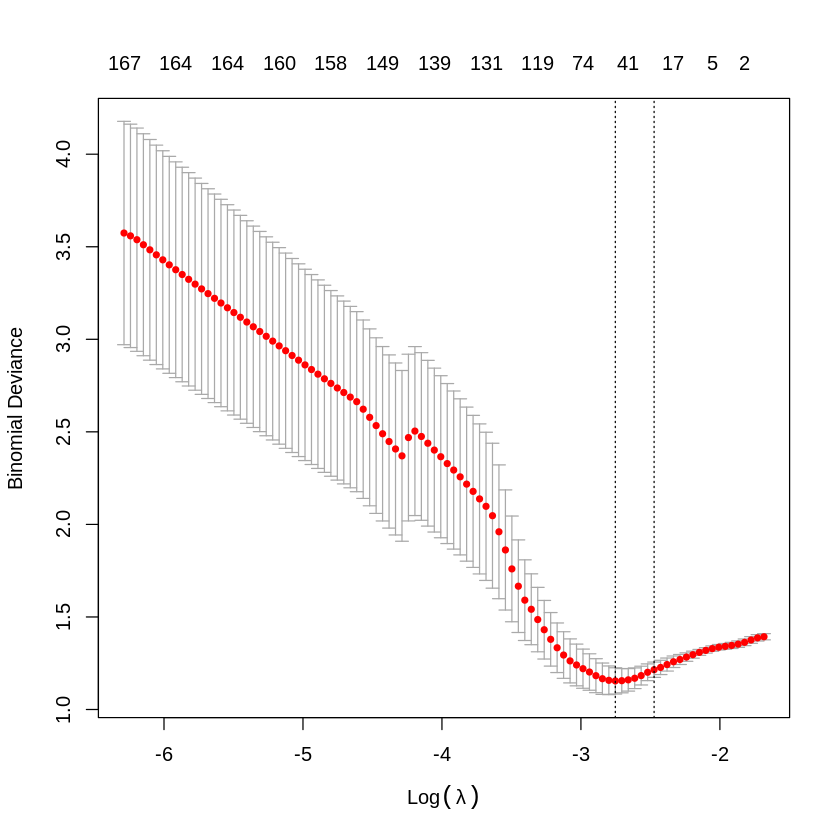

In [63]:
set.seed(1)
crossValidationOutput <- cv.glmnet(y=factor(dataCancerNoCancer$disease),
                                   x=t(exprs(dataCancerNoCancer)), family="binomial")

plot(crossValidationOutput)

In [64]:
bestLambda = crossValidationOutput$lambda.min
confusionMatrix = predict(lassoFit, newx = t(exprs(dataCancerNoCancer)), type="class",s=bestLambda)

In [65]:
sum(coef(lassoFit, s = bestLambda) != 0)

[1] 47

According to the cross validation, 47 species of microbes should be included.

ii) Write code to extract the number of false positives (non-cancer patients that are predicted to have cancer) and false negatives (cancer patients that are predicted to not have cancer).

In [66]:
table( Predictions=confusionMatrix,TrueValues=dataCancerNoCancer$disease)

           TrueValues
Predictions cancer  n
     cancer     44  2
     n           9 59

According to the matrix, there are 2 false positives and 9 false negatives.

## 3.  Elastic Net regression

The characteristic feature of Ridge regression is the penalty

$$\mbox{log}\left(L(\beta)\right) - \lambda \sum_i  \beta_i ^2,$$

while the penalty for Lasso regression is

$$\mbox{log}\left(L(\beta)\right) - \lambda \sum_i | \beta_i |.$$

In this Problem Set, we explore the penalty

$$\mbox{log}\left(L(\beta)\right) - \lambda \left(\alpha \sum_i | \beta_i | +  (1-\alpha) \sum_i  \beta_i ^2\right),$$

which is called __Elastic Net__.  

i) In parameter space, Ridge Regression corresponds to finding optimal parameters on a circle, while LASSO regression corresponds to finding optimal parameters on a diamond. What shape does Elastic Net correspond to?

It would be between a diamond and a circle, so square-ish circle.

ii). The `glmnet` package was built for Elastic Net regression. Look up the [glmnet package help files](https://www.rdocumentation.org/packages/glmnet/versions/3.0-2/topics/glmnet) to find out how to perform Elastic Net regression for a specific $\alpha$. Do this for $\alpha=0.5$, and return the confusion matrix.

In [68]:
enr <- glmnet(y=factor(dataCancerNoCancer$disease),
                                   x=t(exprs(dataCancerNoCancer)), family="binomial",  alpha=0.5)
crossValidationOutput <- cv.glmnet(y=factor(dataCancerNoCancer$disease),
                                   x=t(exprs(dataCancerNoCancer)), family="binomial",  alpha=0.5)
bestLambda = crossValidationOutput$lambda.min
confusionMatrix = predict(enr, newx = t(exprs(dataCancerNoCancer)), type="class",s=bestLambda)
table(confusionMatrix,dataCancerNoCancer$disease)

               
confusionMatrix cancer  n
         cancer     47  1
         n           6 60

iii) Perform a sweep over $\alpha=0$ to $\alpha=1$. Plot the number of species included versus $\alpha$.

Hint: The cv.glmnet output object has a returns a value `$nzero`, which is the number of nonzero factors, which is the number of species desired.  

In [94]:
false_pos <- list()
false_neg <- list()
n_species <- list()

for (i in seq(0, 1, by = 0.05)) {
  enr2 = glmnet(y=factor(dataCancerNoCancer$disease),
                                   x=t(exprs(dataCancerNoCancer)),family="binomial",alpha = i)
  crossValidationOutput <- cv.glmnet(y=factor(dataCancerNoCancer$disease),
                                   x=t(exprs(dataCancerNoCancer)), family="binomial",  alpha=i)
  bestLambda = crossValidationOutput$lambda.min

  n <- sum(coef(lassoFit, s = bestLambda) != 0)
  n_species <- c(n_species,n)
  confusionMatrix = predict(enr, newx = t(exprs(dataCancerNoCancer)), type="class",s=bestLambda)
  tab <- table(Predictions=confusionMatrix,TrueValues=dataCancerNoCancer$disease)
    false_pos <- c(false_pos,as.list(tab)[3])
    false_neg <- c(false_neg,as.list(tab)[2])

}

In [95]:
false_pos[false_pos=='NULL'] <- 0
false_neg[false_neg=='NULL'] <- 0

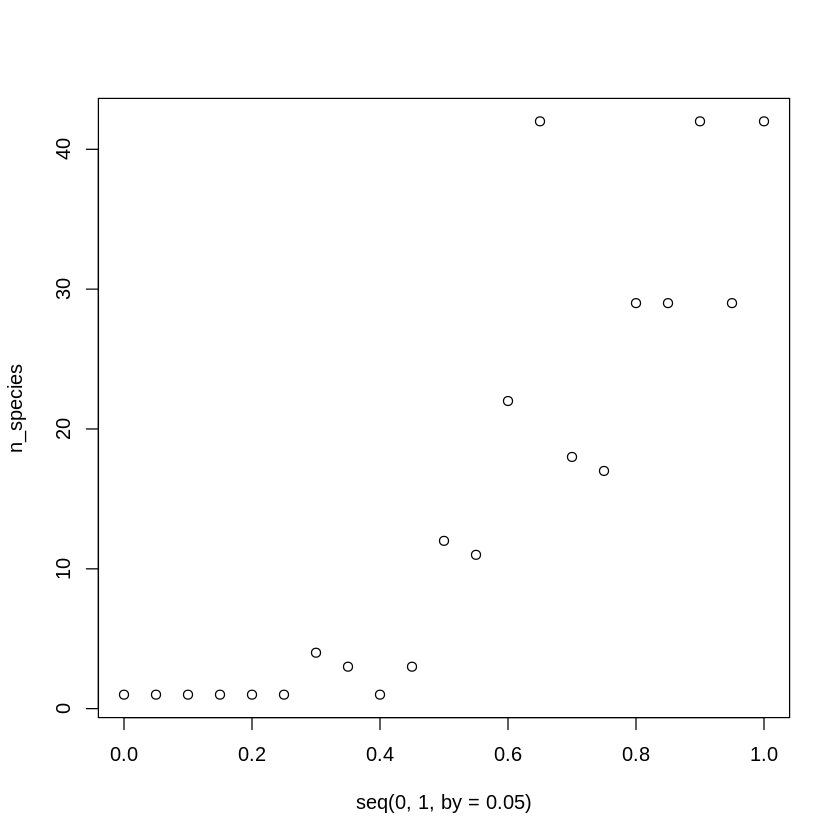

In [96]:
plot(seq(0, 1, by = 0.05), n_species)

iv) What $\alpha$ value minimizes the number of false positives (non-cancer patients that are predicted to have cancer)? What $\alpha$ value minimizes the number of false negatives (cancer patients that are predicted to not have cancer)?

In [106]:
list1 <- false_pos
names(list1) <- c(seq(0, 1, by=0.05))
list1[which.min(list1)]

list1 <- false_neg
names(list1) <- c(seq(0, 1, by=0.05))
list1[which.min(list1)]

$`0`
[1] 0

$`0.65`
[1] 2

When alpha=0 it minimizes the number of false positives, and when alpha=0.65 it minimizes the number of false negatives.